# 處理 outliers
* 新增欄位註記
* outliers 或 NA 填補
    1. 平均數 (mean)
    2. 中位數 (median, or Q50)
    3. 最大/最小值 (max/min, Q100, Q0)
    4. 分位數 (quantile)

# [教學目標]
為了要處理離群值, 我們要先學會計算其他的統計量, 並且還有其他的挑整方式

# [範例重點]
- 計算並觀察百分位數 (In[4], In[7])
- 計算中位數的方式 (In[8])
- 計算眾數 (In[9], In[10])
- 計算標準化與最大最小化 (In[11])

In [28]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
f_app = 'application_train.csv'
print('Path of read in data: %s' % (f_app))
app_train = pd.read_csv(f_app)
app_train.head()

Path of read in data: application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# 如果欄位中有 NA, describe 會有問題
app_train['AMT_ANNUITY'].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [31]:
app_train['AMT_ANNUITY'].isnull().sum()

12

In [32]:
# Ignore NA, 計算五值
five_num = [0, 25, 50, 75, 100]
quantile_5s = [np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = i) for i in five_num]
print(quantile_5s)

[1615.5, 16524.0, 24903.0, 34596.0, 258025.5]


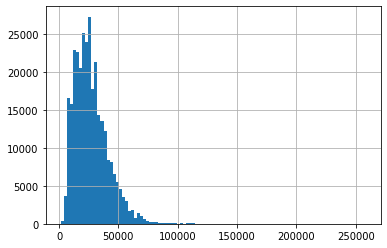

In [33]:
app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'].hist(bins = 100)
plt.show()

In [35]:
# 試著將 max 取代為 q99
# why
mi = app_train[app_train['AMT_ANNUITY'] == app_train['AMT_ANNUITY'].max()].index
app_train.loc[mi, 'AMT_ANNUITY'] = np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = 99)

In [38]:
app_train.loc[17948, 'AMT_ANNUITY']  # 把整列值都換掉了欸

70006.5

In [39]:
five_num = [0, 25, 50, 75, 100]
quantile_5s = [np.percentile(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'], q = i) for i in five_num]
print(quantile_5s)

[1615.5, 16524.0, 24903.0, 34596.0, 230161.5]


In [42]:
# 得到 median 的另外一種方法
np.median(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'])

24903.0

In [43]:
# 計算眾數 (mode)
from scipy.stats import mode
import time

start_time = time.time()
mode_get = mode(app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY'])
print(mode_get)
print("Elapsed time: %.3f secs" % (time.time() - start_time))

ModeResult(mode=array([9000.]), count=array([6385]))
Elapsed time: 0.162 secs


In [44]:
# 計算眾數 (mode)
# 較快速的方式
from collections import defaultdict

start_time = time.time()
mode_dict = defaultdict(lambda:0)

for value in app_train[~app_train['AMT_ANNUITY'].isnull()]['AMT_ANNUITY']:
    mode_dict[value] += 1
    
mode_get = sorted(mode_dict.items(), key=lambda kv: kv[1], reverse=True)
print(mode_get[0])
print("Elapsed time: %.3f secs" % (time.time() - start_time))

(9000.0, 6385)
Elapsed time: 0.230 secs


## 連續值標準化
### 1. Z-transform: $ \frac{(x - mean(x))}{std(x)} $
### 2. Range (0 ~ 1): $ \frac{x - min(x)}{max(x) - min(x)} $
### 3. Range (-1 ~ 1): $ (\frac{x - min(x)}{max(x) - min(x)} - 0.5) * 2 $

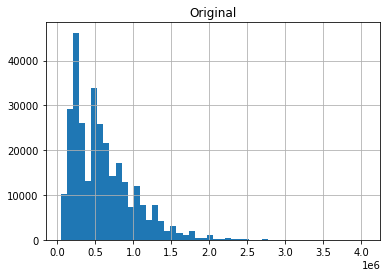

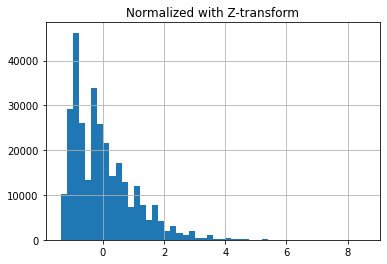

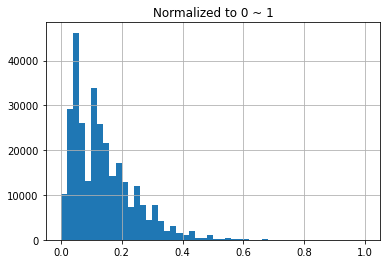

In [45]:
# 以 AMT_CREDIT 為例
app_train['AMT_CREDIT'].hist(bins = 50)
plt.title("Original")
plt.show()
value = app_train['AMT_CREDIT'].values  # 另外宣告出來

app_train['AMT_CREDIT_Norm1'] = ( value - np.mean(value) ) / ( np.std(value) )
app_train['AMT_CREDIT_Norm1'].hist(bins = 50)
plt.title("Normalized with Z-transform")
plt.show()

app_train['AMT_CREDIT_Norm2'] = ( value - min(value) ) / ( max(value) - min(value) )
app_train['AMT_CREDIT_Norm2'].hist(bins = 50)
plt.title("Normalized to 0 ~ 1")
plt.show()

# It's your turn
### 1. 列出 AMT_ANNUITY 的 q0 - q100
### 2.1 將 AMT_ANNUITY 中的 NAs 暫時以中位數填補
### 2.2 將 AMT_ANNUITY 的數值標準化至 -1 ~ 1 間
### 3. 將 AMT_GOOD_PRICE 的 NAs 以眾數填補
